In [9]:
using BenchmarkTools
using Plots
using DRR
using Distributed
using SharedArrays

In [2]:
# Read the volume
volume, ΔX, ΔY, ΔZ = read_dicom("../data/cxr"; pad=true)
# volume = volume[:, :, 2:end-1]
grid, pixels = volume2grid(volume, ΔX, ΔY, ΔZ)

# Define the camera
center = Vec3(180., 180., -100)
camera = Camera(center)

# Define the detector plane
center = Vec3(180., 180., 500.)
normal = Vec3(1., -1., -1.)
height, width = 601, 601
Δx, Δy = 2., 2.
detector = Detector(center, normal, height, width, Δx, Δy)

Detector(Vec3{Float64}(180.0, 180.0, 500.0), Vec3{Float64}(1.0, -1.0, -1.0), 601, 601, 2.0, 2.0)

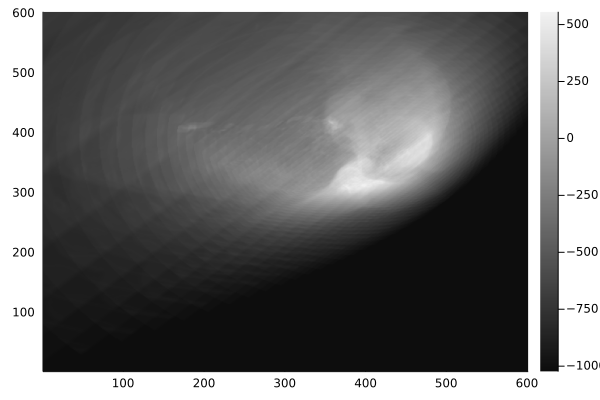

In [3]:
# Generate the DRR
spacing = 0.02
drr = make_drr(grid, pixels, camera, detector, spacing)
heatmap(drr, c=:grays)

In [13]:
function paradrr(projector, spacing, grid, pixels)
    
    function raytrace_trilinear(ray, spacing::Float64, grid, pixels)
        pts = trace.(0:spacing:1; ray=ray)
        interpolations = interpolate.(pts; grid, pixels)
        return sum(interpolations) / length(pts)
    end
    
    drr = SharedArray{Float64}(length(projector))
    @distributed for i in 1:length(projector)
        ray = projector[i]
        drr[i] = raytrace_trilinear(ray, spacing, grid, pixels)
    end
    return drr
end

#=function raytrace_trilinear(ray, spacing::Float64, grid, pixels)
    pts = trace.(0:spacing:1; ray=ray)
    interpolations = interpolate.(pts; grid, pixels)
    return sum(interpolations) / length(pts)
end=#

paradrr (generic function with 1 method)

In [5]:
findz(x, y; a, b, c, d) = (d - a * x - b * y) / c
findz(x::Tuple{Float64,Float64}; a, b, c, d) = findz(x[1], x[2]; a, b, c, d)
append(xy, z) = Vec3(xy..., z)

# Construct the detector array
function make_plane(detector::Detector)
    d = dotprod(detector.center, detector.normal)
    xs = (-detector.height÷2:1:detector.height÷2) * detector.Δx
    ys = (-detector.width÷2:1:detector.width÷2) * detector.Δy
    xys = product(xs, ys) |> collect
    zs = findz.(xys; a=detector.normal.x, b=detector.normal.y, c=detector.normal.z, d=d)
    return append.(xys, zs)
end
get_rays(camera, plane) = [Ray(camera.center, pixel - camera.center) for pixel in plane]

get_rays (generic function with 1 method)

In [6]:
import Base: product
# Set up the detector plane
plane = make_plane(detector)
projector = get_rays(camera, plane);

In [7]:
function make_drr1(projector, spacing, grid, pixels)
    drr = Array{Float64}(undef, length(projector))
    for i in 1:length(projector)
        ray = projector[i]
        drr[i] = raytrace_trilinear(ray, spacing, grid, pixels)
    end
    return drr
end

make_drr1 (generic function with 1 method)

In [8]:
# add workers
if nworkers()==1
  addprocs(5; exeflags="--project=../")  
  println(workers())
end

[2, 3, 4, 5, 6]


In [18]:
@everywhere begin 
    using Pkg; Pkg.activate("../")  # required
    include("../src/DRR.jl")
    
end

      From worker 2:	  Activating project at `C:\Users\rubyl\OneDrive\Documents\School\Parallel Computing\FinalProject\DRR.jl`
      From worker 4:	  Activating project at `C:\Users\rubyl\OneDrive\Documents\School\Parallel Computing\FinalProject\DRR.jl`
      From worker 6:	  Activating project at `C:\Users\rubyl\OneDrive\Documents\School\Parallel Computing\FinalProject\DRR.jl`
      From worker 5:	  Activating project at `C:\Users\rubyl\OneDrive\Documents\School\Parallel Computing\FinalProject\DRR.jl`
      From worker 3:	  Activating project at `C:\Users\rubyl\OneDrive\Documents\School\Parallel Computing\FinalProject\DRR.jl`


  Activating project at `C:\Users\rubyl\OneDrive\Documents\School\Parallel Computing\FinalProject\DRR.jl`


In [19]:
@btime paradrr(projector, spacing, grid, pixels);

Unhandled Task ERROR: On worker 2:
TypeError: in typeassert, expected Core.TypeName, got a value of type Nothing
Stacktrace:
  [1] deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Distributed\src\clusterserialize.jl:64
  [2] handle_deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:947
  [3] deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:801
  [4] handle_deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:858
  [5] deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:801
  [6] deserialize_datatype
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:1356
  [7] handle_deserialize
    

  2.721 s (11037 allocations: 875.91 KiB)


Unhandled Task ERROR: On worker 2:
TypeError: in typeassert, expected Core.TypeName, got a value of type Nothing
Stacktrace:
  [1] deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Distributed\src\clusterserialize.jl:64
  [2] handle_deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:947
  [3] deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:801
  [4] handle_deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:858
  [5] deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:801
  [6] deserialize_datatype
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:1356
  [7] handle_deserialize
    